In [210]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

In [180]:
datas = []
entries = pathlib.Path('data/')
summation = 0

for entry in entries.iterdir():
    data = np.genfromtxt(entry, delimiter=',')
    summation += data.shape[0]
    print(data.shape)
    mean_data, std_data = np.mean(data, axis=0), np.std(data, axis=0)
    normalize_data = (data - mean_data)/std_data
    data = torch.from_numpy(normalize_data)
    datas.append(data)

print('summation =',summation)

(29297, 9)
(31254, 9)
(32227, 9)
(33205, 9)
(32228, 9)
(30276, 9)
(31250, 9)
(31250, 9)
(25934, 9)
(30280, 9)
(31250, 9)
(31251, 9)
(31251, 9)
(32228, 9)
(31251, 9)
(30275, 9)
summation = 494707


In [181]:
df = pd.read_csv('data/Output-S2-1.csv', header=None)
df = df.dropna(axis=0)

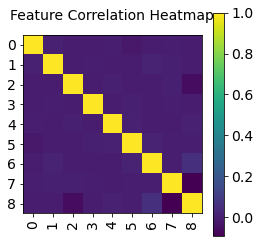

In [182]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

mean = 0.595 || std = 0.052008333333333344


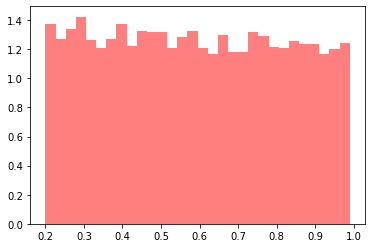

In [183]:
x0 = df.iloc[:10000, 0].values
n, bins, patches = plt.hist(x0, 30, density=1, facecolor='r', alpha=0.5)
a = 0.2
b = 0.99
mean = (a + b)/2
std = (b - a)**2/12
print('mean =',mean,'||','std =', std)

mean = 0.595 || std = 0.052008333333333344


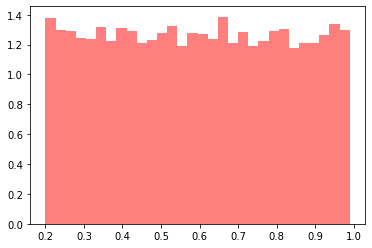

In [184]:
x1 = df.iloc[:10000, 1].values
n, bins, patches = plt.hist(x1, 30, density=1, facecolor='r', alpha=0.5)
a = 0.2
b = 0.99
mean = (a + b)/2
std = (b - a)**2/12
print('mean =',mean,'||','std =', std)

mean = 0.4 || std = 0.12


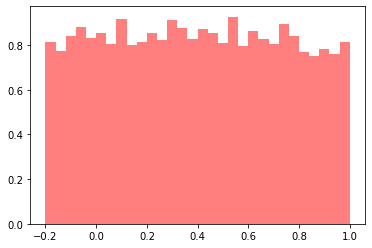

In [185]:
x2 = df.iloc[:10000, 2].values
n, bins, patches = plt.hist(x2, 30, density=1, facecolor='r', alpha=0.5)
a = -0.2
b = 1
mean = (a + b)/2
std = (b - a)**2/12
print('mean =',mean,'||','std =', std)

mean = 0.505 || std = 0.081675


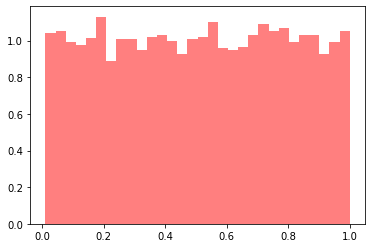

In [186]:
x3 = df.iloc[:10000, 3].values
n, bins, patches = plt.hist(x3, 30, density=1, facecolor='r', alpha=0.5)
a = 0.01
b = 1
mean = (a + b)/2
std = (b - a)**2/12
print('mean =',mean,'||','std =', std)

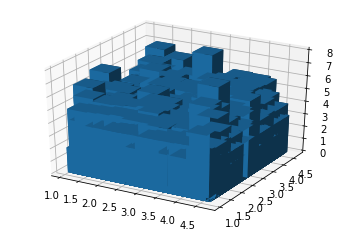

mean = 2.4 || std = 0.8533333333333335


In [187]:
x4 = df.iloc[:10000, 4].values
x5 = df.iloc[:10000, 5].values
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(x4, x5, bins=75, range=[[0.8, 4], [0.8, 4]])

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()

a = 0.8
b = 4
mean = (a + b)/2
std = (b - a)**2/12
print('mean =',mean,'||','std =', std)

mean = 0.4 || std = 0.12


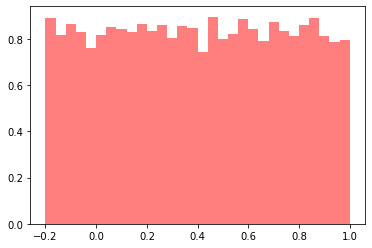

In [188]:
x6 = df.iloc[:10000, 6].values
n, bins, patches = plt.hist(x6, 30, density=1, facecolor='r', alpha=0.5)
a = -0.2
b = 1
mean = (a + b)/2
std = (b - a)**2/12
print('mean =',mean,'||','std =', std)

mean = 0.505 || std = 0.081675


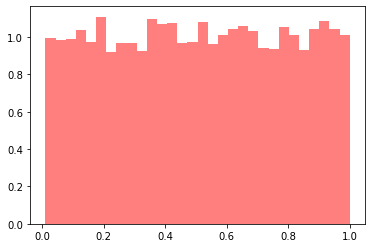

In [189]:
x7 = df.iloc[:10000, 7].values
n, bins, patches = plt.hist(x7, 30, density=1, facecolor='r', alpha=0.5)
a = 0.01
b = 1
mean = (a + b)/2
std = (b - a)**2/12
print('mean =',mean,'||','std =', std)

In [196]:
train_ratio = 0.80
i = int(df.shape[0] * train_ratio)
print(df.shape)
train_set =  df[0:i]
test_set  =  df[i:] 
print(train_set.shape)
print(test_set.shape)

x_train = torch.from_numpy(train_set.iloc[:,0:8].values)
y_train = torch.from_numpy(train_set.iloc[:,-1].values)

x_test = torch.from_numpy(test_set.iloc[:,0:8].values)
y_test = torch.from_numpy(test_set.iloc[:,-1].values)

(31249, 9)
(24999, 9)
(6250, 9)


In [197]:
# Definition of some hyperparameters taken from lab10
learning_rate = 1e-3
num_epochs = 1
batch_size = 1000

dataset_train_tensor = torch.utils.data.TensorDataset(x_train.float(), y_train.float())
dataset_test_tensor= torch.utils.data.TensorDataset(x_test.float(), y_test.float())

dataset_train = torch.utils.data.DataLoader(dataset_train_tensor, batch_size=batch_size)
dataset_test = torch.utils.data.DataLoader(dataset_test_tensor, batch_size=100)

In [198]:
def accuracy(predicted_logits, reference):
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

In [199]:
# Taken from lab10
def train(model, criterion, dataset_train, dataset_test, optimizer, num_epochs):
    print("Starting training")
    for epoch in range(num_epochs):
    # Train an epoch
        model.train()
        for batch_x, batch_y in dataset_train:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            loss = criterion(prediction, batch_y)

            # Compute the gradient
            optimizer.zero_grad()
            loss.backward()

            # Update the parameters of the model with a gradient step
            optimizer.step()

    # Test the quality on the test set
    model.eval()
    accuracies_test = []
    for batch_x, batch_y in dataset_test:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Evaluate the network (forward pass)
        prediction = model(batch_x)
        #accuracies_test.append(accuracy(prediction, batch_y))

    #print("Epoch {} | Test accuracy: {:.5f}".format(epoch, sum(accuracies_test).item()/len(accuracies_test)))
class OTCmodel(nn.Module):
    def _init_(self):
        super()._init_()
        # For the moment i just used the architecture of LeNet because i have no idea where to start :)
        self.conv1 = nn.Conv1d(1, 30, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(30, 60, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(120, 20)
        self.conv_drop = torch.nn.Dropout()
        self.fc2 = nn.Linear(20, 1)
  
    def forward(self, x):
        relu = nn.functional.relu
        max_pool1d = torch.nn.functional.max_pool1d

        x = relu(max_pool1d(self.conv1(x), 2))
        print(x)
        x = relu(max_pool1d(self.conv_drop(self.conv2(x)), 2))
        x = x.view(-1, 120)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [200]:
# If a GPU is available use cuda else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_otc = OTCmodel().to(device)

# Defining the loss function and the optimizer the best to use is adam()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model_otc.parameters(), lr=learning_rate)

# training
train(model_otc, criterion, dataset_train, dataset_test, optimizer, num_epochs)


ValueError: optimizer got an empty parameter list

# Testing with XGboost

In [208]:
x_train = train_set.iloc[:,0:8].values
y_train = train_set.iloc[:,-1].values
x_test = test_set.iloc[:,0:8].values
y_test = test_set.iloc[:,-1].values
xgbr = XGBRegressor(verbosity=0)
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [209]:
ypred_x = xgbr.predict(x_test)
mse_x = mean_squared_error(y_test, ypred_x)
print("MSE: %.2f" % mse_x)

MSE: 11.35
